# 00. 🔍 Intenção de Pesquisa

## Responder às seguintes questões

1. Existe relação entre as informações demográficas do indivíduo e a sua renda?
2. Existe correlação entre essas informações demográficas? Se sim, quais?

Para tanto, pretende-se usar métodos estatísticos para analisar as distribuições e avaliar a correlação dentro das variáveis categóricas e dentro das numéricas

# 01. 📑 Importações

In [206]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
import seaborn as sns
import yaml

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# 02. 📖 Lendo Dados

In [65]:
df = pd.read_csv('../data/01_raw/income.csv')
df.sample()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
18709,59,Private,114678,HS-grad,9,Never-married,Craft-repair,Not-in-family,Black,Male,0,0,60,United-States,<=50K


# 03. 🧮 Dividindo em Treino e Teste e Analisando

In [66]:
y_col = ['income']
X_col = [col for col in df.columns if col not in y_col]

X = df[X_col]
y = df[y_col]

In [67]:
y['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [68]:
# convertendo rótulos em binário

y['income'] = y['income'].apply(lambda x: 1 if x == '>50K' else 0)
y['income'].unique()

array([0, 1])

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=777)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=.25, random_state=777)

In [70]:
y_train['income'].info()

<class 'pandas.core.series.Series'>
Index: 19536 entries, 31040 to 13263
Series name: income
Non-Null Count  Dtype
--------------  -----
19536 non-null  int64
dtypes: int64(1)
memory usage: 305.2 KB


In [71]:
positive_rate = int(y_train['income'].value_counts()[1] / len(y_train) * 100)
                    
print(f"taxa de positivos: {positive_rate}%")

taxa de positivos: 24%


In [72]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19536 entries, 31040 to 13263
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       19536 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      19536 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19536 non-null  object
dtypes: int64(6), object(8)
memory usage: 2.2+ MB


In [73]:
df['education.num'] = df['education.num'].astype('object') # correção de dtype

In [74]:
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

## 03.a 0️⃣ Análise de Valores Zerados

1. Existem muitos dados zerados nas colunas capital-gain capital-loss
2. Esses valores são realmente 0 ou são valores faltantes que foram preenchidos dessa forma?

In [75]:
X_train[num_cols].describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,19536.000000,1.953600e+04,19536.000000,19536.000000,19536.000000,19536.000000
mean,38.566186,1.898451e+05,10.076730,1030.029023,88.930436,40.512131
std,13.623863,1.058241e+05,2.558434,7204.523369,407.719011,12.308489
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.179630e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784230e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.369408e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.000000,99.000000


<Axes: >

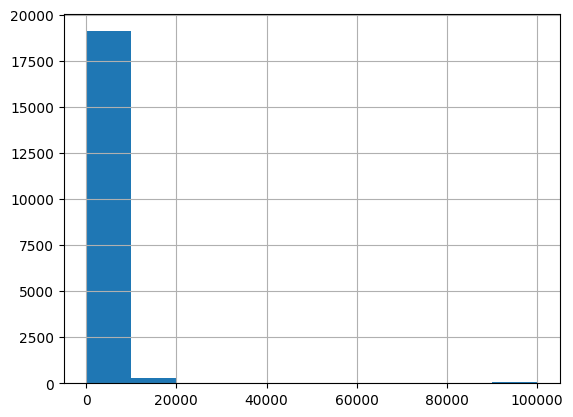

In [76]:
X_train['capital.gain'].hist()

<Axes: >

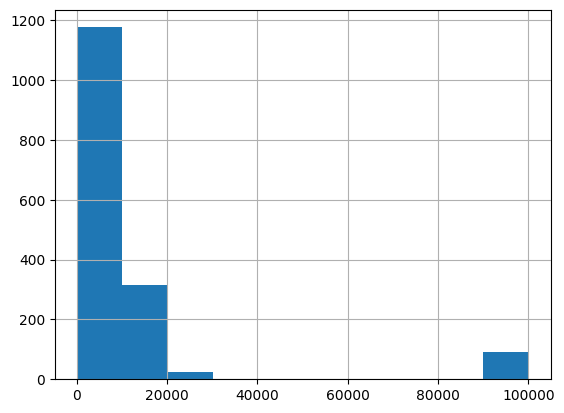

In [77]:
X_train[X_train['capital.gain'] != 0]['capital.gain'].hist()

<Axes: >

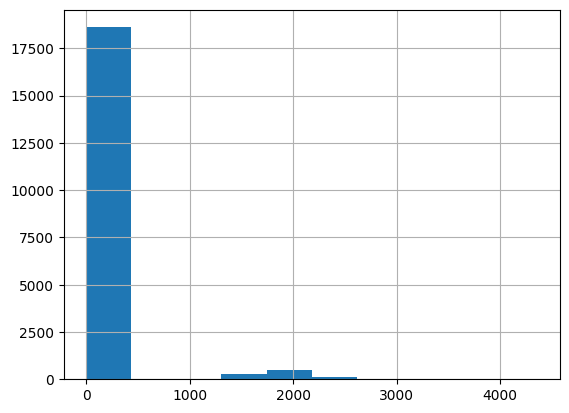

In [78]:
X_train['capital.loss'].hist()

<Axes: >

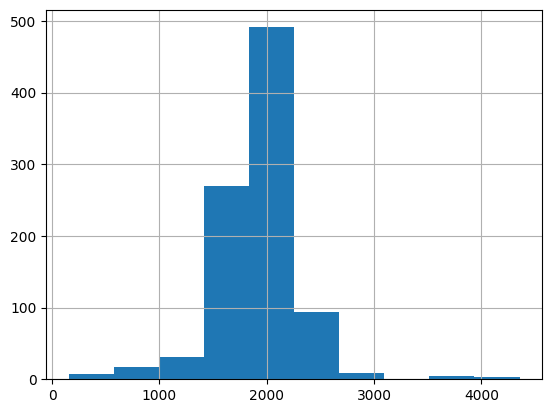

In [79]:
X_train[X_train['capital.loss'] != 0]['capital.loss'].hist()

In [80]:
print(len(X_train[X_train['capital.gain'] == 0]))
print(len(X_train[X_train['capital.gain'] != 0]))

X_train['no.capital.gain'] = X_train['capital.gain'].apply(lambda x: 1 if x == 0 else 0)

X_train['no.capital.gain'] = X_train['no.capital.gain'].astype('object')

17924
1612


In [81]:
print(len(X_train[X_train['capital.loss'] == 0]))
print(len(X_train[X_train['capital.loss'] != 0]))

X_train['no.capital.loss'] = X_train['capital.loss'].apply(lambda x: 1 if x == 0 else 0)

X_train['no.capital.loss'] = X_train['no.capital.loss'].astype('object')

18608
928


In [82]:
cat_cols = X_train.select_dtypes(exclude='number').columns

### Teste Estatístico de Diferença Condicional

Como se tratam de colunas de ganho e perda de capital, vamos escolher colunas para comparar essas distribuições dentro dos dois grupos ("0" e "não 0"), para tanto, vamos escolher colunas que também possuem relação com poder financeiro.

As coluna escolhidas foram: workclass e occupation

O teste escolhido foi: o qui-2, pelo tamanho da amostra

alpha = 0.01

Ho: As variáveis são independentes

### Conclusão

Os zeros não são perdas aleatórias e que foram substituídas por 0. Pois os testes mostraram que há dependència entre eses valores e os das outras colunas

**workclass**

In [83]:
alpha = .01

tab = pd.crosstab(X_train['workclass'], X_train['no.capital.gain'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [84]:
print(p)

4.1738115143294274e-17


In [85]:
alpha = .01

tab = pd.crosstab(X_train['workclass'], X_train['no.capital.loss'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [86]:
print(p)

0.0006442259713468388


**occupation**

In [87]:
alpha = .01

tab = pd.crosstab(X_train['occupation'], X_train['no.capital.gain'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


In [88]:
alpha = .01

tab = pd.crosstab(X_train['occupation'], X_train['no.capital.loss'])

chi2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

temos evidencia para rejeitar Ho. Logo, são dependentes


## 03.b ❓ Análise de "?"

Percebi que algumas colunas categóricas possuem valores "?" (native-country, workclass e occupation). O intuito é averiguar se são valores faltantes aleatórios ou se eles se relacionam com as demais features.

In [89]:
X_train[cat_cols].describe()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,no.capital.gain,no.capital.loss
count,19536,19536,19536,19536,19536,19536,19536,19536,19536,19536
unique,9,16,7,15,6,5,2,42,2,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,1,1
freq,13612,6340,9012,2499,7917,16720,13135,17529,17924,18608


In [90]:
X_train['native.country'].value_counts()[:10]

native.country
United-States    17529
Mexico             375
?                  344
Philippines        123
Germany             89
El-Salvador         66
Puerto-Rico         65
Canada              58
Cuba                58
England             58
Name: count, dtype: int64

In [91]:
X_train['workclass'].value_counts()

workclass
Private             13612
Self-emp-not-inc     1507
Local-gov            1247
?                    1112
State-gov             823
Self-emp-inc          649
Federal-gov           572
Without-pay            10
Never-worked            4
Name: count, dtype: int64

In [92]:
X_train['occupation'].value_counts()

occupation
Craft-repair         2499
Exec-managerial      2467
Prof-specialty       2446
Adm-clerical         2227
Sales                2193
Other-service        1958
Machine-op-inspct    1203
?                    1116
Transport-moving      982
Handlers-cleaners     818
Farming-fishing       562
Tech-support          562
Protective-serv       409
Priv-house-serv        89
Armed-Forces            5
Name: count, dtype: int64

In [93]:
X_train['education.num'].value_counts()

education.num
9     6340
10    4370
13    3213
14     993
11     846
7      698
12     668
6      550
4      386
15     342
5      294
8      259
16     240
3      214
2       99
1       24
Name: count, dtype: int64

In [94]:
def contains_unknown_value(row):
    total = 0
    for v in row:
        if v == '?':
            total += 1
    return total

X_train['unknown.value'] = X_train.apply(contains_unknown_value, axis=1)

In [95]:
X_train['unknown.value'].value_counts()

unknown.value
0    18088
2     1100
1      336
3       12
Name: count, dtype: int64

### Teste Estatístico de Diferença Condicional

Vamos escolher colunas para comparar essas distribuições dentro dos dois grupos ("?" e "não ?"), para tanto, optei por escolher as mesmas colunas usadas anteriormente (ganho e perda de capital)
As coluna escolhidas foram: workclass e occupation

O teste escolhido foi: o qui-2, pelo tamanho da amostra

alpha = 0.01

Ho: As variáveis são independentes

### Conclusão

Os "?" não são perdas aleatórias e que foram substituídas por ?. Pois os testes mostraram que há dependència entre eses valores e os da coluna de ganho de capital. Apesar de não termos evidência o bastante de para rejeitar a Ho no caso da coluna "perda de capital"

In [96]:
alpha = .01

tab = pd.crosstab(X_train['no.capital.gain'], X_train['unknown.value'])

ch2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

não temos evidencia o bastante para rejeitar Ho


In [97]:
print(p)

0.12552487370943133


In [98]:
alpha = .01

tab = pd.crosstab(X_train['no.capital.loss'], X_train['unknown.value'])

ch2, p, dof, expected = chi2_contingency(tab)

if p < alpha:
    print('temos evidencia para rejeitar Ho. Logo, são dependentes')
else:
    print('não temos evidencia o bastante para rejeitar Ho')

não temos evidencia o bastante para rejeitar Ho


In [99]:
print(p)

0.29008404037286145


## 03.c ↔️ Análise de Correlação de Features

### Numéricas

Primeiro vamos averiguar se as variáveis podem ser usadas na corr de pearson, isto é, se satisfazem os seguintes critérios:

1. possuem uma contagem grande o bastante
2. não são muito assimétricas (muitos valores zerados por exemplo)

Aqui temos que as variáveis "age" e "hours-per-week" passam nos critérios.
Contudo, as variáveis contínuas "capital-gain" e "capital-loss" não, por isso vamos ignorar seus valores

*conclusão*: não existe grande correlação entre as variáveis numéricas

<Axes: >

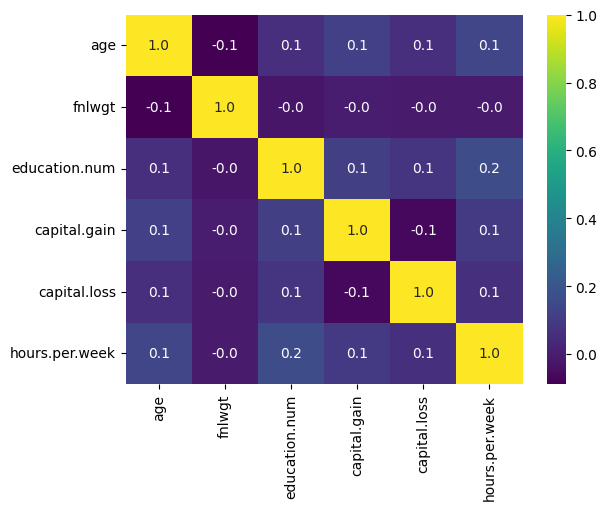

In [100]:
corr = X_train[num_cols].corr('spearman')

sns.heatmap(corr, annot=True, fmt='.1f', cmap='viridis')

### Categóricas

Vamos analisar a correlação usando um tipo de normalização do chi2 chamado v_cramer.

*conclusões:*

1. education e educational-num são equivalentes
2. existe grande correlação entre relationship, gender, marital status e occupation (acredito que muito em função das associações homem~marido e mulher~esposa)

Dado que gender possui considerável correlação entre genero e outras colunas, optou-se por manter as demais, pois elas já compreendem informação de gender e agregam outras.

Além disso, optou-se por remover a redundância de education

In [101]:
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.values.sum()
    r, c = table.shape
    return np.sqrt(chi2 / (n * (min(r, c) - 1)))

In [102]:
cramer_matrix = pd.DataFrame(
    np.zeros((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        cramer_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])

<Axes: >

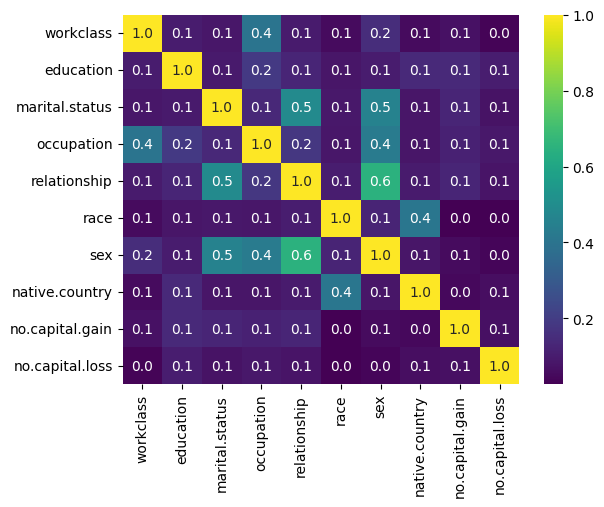

In [103]:
sns.heatmap(cramer_matrix, annot=True, fmt='.1f', cmap='viridis')

In [104]:
drop_cols = ['gender', 'education.num', 'no.capital.gain', 'no.capital.loss']

# 04. 🧪 Modelagem

## 04.a Naive Bayes

In [105]:
cat_cols = [col for col in cat_cols if not col in drop_cols]

In [106]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

ct = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', num_pipe, num_cols)
    ],
    remainder='drop'
)

pipe = Pipeline(steps=[
    ('ct', ct),
    ('nb', BernoulliNB())
])

param_grid = {
    'nb__alpha': [1e-3, 1e-2, 1e-1, 0.5, 1, 2, 5, 10],
    'nb__fit_prior': [True, False],
    
}

nb = GridSearchCV(pipe, param_grid, cv=10, scoring='f1', n_jobs=-1)

nb.fit(X_train, y_train)

print(nb.best_score_)
print(nb.best_estimator_)
print(nb.best_params_)

/opt/homebrew/Cellar/python@3.11/3.11.14_2/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_2/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.11/3.11.14_2/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API.

0.6359007374602804
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country']),
                                                 ('num',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=10)),
                                                                  ('ohe',
                                           

## 04.b Logistic Regression

In [107]:
ct = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('ss', StandardScaler(), num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('lreg', LogisticRegression())
])

param_grid = [
    {
        "lreg__solver": ["lbfgs"],
        "lreg__penalty": ["l2"],
        "lreg__C": [0.1, 1, 5, 10, 20, 50]
    },
    {
        "lreg__solver": ["liblinear"],
        "lreg__penalty": ["l1", "l2"],
        "lreg__C": [0.1, 1, 5, 10, 20, 50]
    },
    {
        "lreg__solver": ["saga"],
        "lreg__penalty": ["elasticnet"],
        "lreg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
        "lreg__C": [0.1, 1, 5, 10, 20, 50]
    }
]

lreg = GridSearchCV(pipe, param_grid, cv=10, scoring='f1', n_jobs=-1)

lreg.fit(X_train, y_train)

print(lreg.best_score_)
print(lreg.best_estimator_)
print(lreg.best_params_)

0.6547084433822815
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country']),
                                                 ('ss', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'))])),
                ('lreg',
                 LogisticRegression(C=5, penalty='l2', solver='liblinear'))])
{'lreg__C': 5, '

## 04.c CatBoost

In [108]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('num_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_pipe', num_pipe, num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('cb', CatBoostClassifier())
])

param_grid = {
    'cb__thread_count': [-1],
    'cb__logging_level': ['Silent'],
    "cb__iterations": [500, 800],
    "cb__depth": [6, 8],
    "cb__learning_rate": [0.05, 0.1],
    "cb__l2_leaf_reg": [3, 5],
    "cb__subsample": [0.8, 1.0],
    "cb__loss_function": ["Logloss"],
    "cb__eval_metric": ["F1"],
    "cb__auto_class_weights": ["Balanced"],
}

cb = GridSearchCV(pipe, param_grid, cv=10, scoring='f1', n_jobs=-1)

cb.fit(X_train, y_train)

print(cb.best_score_)
print(cb.best_params_)
print(cb.best_estimator_)

nan
{'cb__auto_class_weights': 'Balanced', 'cb__depth': 6, 'cb__eval_metric': 'F1', 'cb__iterations': 500, 'cb__l2_leaf_reg': 3, 'cb__learning_rate': 0.05, 'cb__logging_level': 'Silent', 'cb__loss_function': 'Logloss', 'cb__subsample': 0.8, 'cb__thread_count': -1}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country']),
                                                 ('num_pipe',
                                                  Pipelin

## 04.d Decision Tree

In [109]:
num_pipe = Pipeline(steps=[
    ('bin', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')),
    ('num_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_pipe', num_pipe, num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('dt', DecisionTreeClassifier())
])

param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [3, 5, 10, 12, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 5, 10],
    'dt__max_features': ['sqrt', 'log2'],
}

dt = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring='f1', n_jobs=-1)

dt.fit(X_train, y_train)

print(dt.best_score_)
print(dt.best_params_)
print(dt.best_estimator_)

0.5812955894900181
{'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country']),
                                                 ('num_pipe',
                                                  Pipeline(steps=[('bin',
                                                                   KBinsDiscretizer(encode='o

## 04.e Random Forest

In [110]:
ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_ss', StandardScaler(), num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('rf', RandomForestClassifier())
])

param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [3, 7, 12],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': ['sqrt'],
}

rf = GridSearchCV(pipe, param_grid, cv=10, scoring='f1', n_jobs=-1)

rf.fit(X_train, y_train)

print(rf.best_score_)
print(rf.best_params_)
print(rf.best_estimator_)

0.6505166613302286
{'rf__criterion': 'gini', 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country']),
                                                 ('num_ss', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtyp

## 04.f SVM

In [111]:
ct = ColumnTransformer(transformers=[
    ('cat_ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num_ss', StandardScaler(), num_cols)
])

pipe = Pipeline(steps=[
    ('ct', ct),
    ('svc', SVC())
])

param_grid = {
    "svc__kernel": ["rbf"],
    "svc__C": [1, 5, 10],
    "svc__gamma": ["scale", 0.05, 0.1],
    "svc__class_weight": ["balanced"],
    "svc__probability": [True]
}

svc = GridSearchCV(pipe, param_grid, cv=10, scoring='f1', n_jobs=-1)

svc.fit(X_train, y_train)

print(svc.best_score_)
print(svc.best_params_)
print(svc.best_estimator_)

0.6793779746182789
{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__probability': True}
Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native.country']),
                                                 ('num_ss', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week'],
      dtype='object'

# 05. 📏 Escolha do Melhor Modelo e Threshold

## Curva Precision-Recall

In [117]:
y_score_nb = nb.predict_proba(X_val)[:, 1]
y_score_lreg = lreg.predict_proba(X_val)[:, 1]
#y_score_cb = cb.predict_proba(X_val)[:, 1]
y_score_dt = dt.predict_proba(X_val)[:, 1]
y_score_rf = rf.predict_proba(X_val)[:, 1]
y_score_svc = svc.predict_proba(X_val)[:, 1]

In [118]:
pr_nb, rec_nb, thresholds_nb = precision_recall_curve(y_val, y_score_nb)
pr_lreg, rec_lreg, thresholds_lreg = precision_recall_curve(y_val, y_score_lreg)
#pr_cb, rec_cb, _ = precision_recall_curve(y_val, y_score_cb)
pr_dt, rec_dt, thresholds_dt = precision_recall_curve(y_val, y_score_dt)
pr_rf, rec_rf, thresholds_rf = precision_recall_curve(y_val, y_score_rf)
pr_svc, rec_svc, thresholds_svc = precision_recall_curve(y_val, y_score_svc)

auc1 = auc(rec_nb, pr_nb)
auc2 = auc(rec_lreg, pr_lreg)
#auc3 = auc(rec_cb, pr_cb)
auc4 = auc(rec_dt, pr_dt)
auc5 = auc(rec_rf, pr_rf)
auc6 = auc(rec_svc, pr_svc)

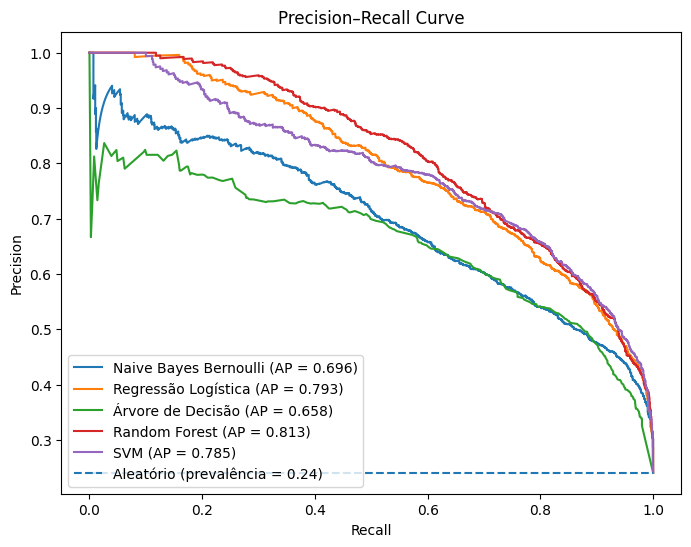

In [119]:
plt.figure(figsize=(8, 6))

plt.plot(rec_nb, pr_nb, label=f'Naive Bayes Bernoulli (AP = {auc1:.3f})')
plt.plot(rec_lreg, pr_lreg, label=f'Regressão Logística (AP = {auc2:.3f})')
#plt.plot(rec_cb, pr_cb, label=f'CatBoost (AP = {auc3:.3f})')
plt.plot(rec_dt, pr_dt, label=f'Árvore de Decisão (AP = {auc4:.3f})')
plt.plot(rec_rf, pr_rf, label=f'Random Forest (AP = {auc5:.3f})')
plt.plot(rec_svc, pr_svc, label=f'SVM (AP = {auc6:.3f})')

baseline = y_test.mean()
plt.hlines(
    y=baseline,
    xmin=0,
    xmax=1,
    linestyles='--',
    label=f'Aleatório (prevalência = {baseline[0]:.2f})'
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


## Escolha do Melhor Threshold

In [175]:
target_recall = 0.7

valid_idx = np.where(rec_rf[:-1] >= target_recall)[0]

In [176]:
best_idx = valid_idx[np.argmax(pr_rf[valid_idx])]
chosen_threshold = thresholds_rf[best_idx]

In [177]:
best_pipeline = rf.best_estimator_
best_model = best_pipeline.fit(pd.concat([X_train, X_val], axis=0), pd.concat([y_train, y_val], axis=0))

# 06. 🎯 Avaliação do Modelo Escolhido

*Escolhido:* Random Forest

*Motivos:* critério objetivo é a maior taxa de acerto dentro da medida escolhida. Porém, a diferença é pouco significativa, logo o critério para cravar a decisão foi a dominancia da PR-curve e a interpretabilidade razoável via features importance.

In [178]:
y_test_scores = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_test_scores >= chosen_threshold).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      4945
           1       0.71      0.69      0.70      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.80      0.80      6513
weighted avg       0.86      0.86      0.86      6513



In [186]:
y_score_rf = rf.predict_proba(X_test)[:, 1]
pr_rf, rc_rf, thresholds_rf = precision_recall_curve(y_test, y_score_rf)
auc_rf = auc(rc_rf, pr_rf)

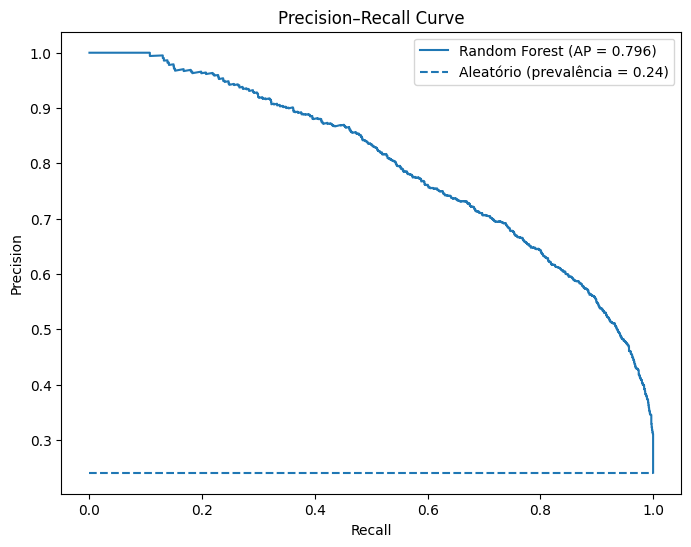

In [189]:
plt.figure(figsize=(8, 6))

plt.plot(rc_rf, pr_rf, label=f'Random Forest (AP = {auc_rf:.3f})')
baseline = y_test.mean()
plt.hlines(
    y=baseline,
    xmin=0,
    xmax=1,
    linestyles='--',
    label=f'Aleatório (prevalência = {baseline[0]:.2f})'
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


In [220]:
def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        return obj

In [225]:
best_model_params = best_model.named_steps['rf'].get_params()

with open("../conf/base/parameters.yml", "r") as f:
    parameters = yaml.safe_load(f)

parameters['model_params'] = best_model_params
parameters['model_params']['random_state'] = 777
parameters['model_configs'] = {}
parameters['model_configs']['model_type'] = 'RandomForestClassifier'
parameters['model_configs']['threshold'] = chosen_threshold

parameters = convert_numpy(parameters)

with open("../conf/base/parameters.yml", "w") as f:
    yaml.dump(parameters, f, sort_keys=False)

# 07. 🎓 Análise de Interpretabilidade

In [179]:
feature_importances = rf.best_estimator_.named_steps['rf'].feature_importances_
features_names = rf.best_estimator_.named_steps['ct'].get_feature_names_out()

In [180]:
coef_df = pd.DataFrame({
    'feature': features_names,
    'coef': feature_importances.round(2),
    'abs_coef': np.abs(feature_importances.round(2))
}).sort_values('abs_coef', ascending=False)

In [181]:
coef_df.head(20)

,feature,coef,abs_coef
24,cat_ohe__marital.status_Married-civ-spouse,0.16,0.16
97,num_ss__capital.gain,0.15,0.15
96,num_ss__education.num,0.11,0.11
26,cat_ohe__marital.status_Never-married,0.07,0.07
94,num_ss__age,0.07,0.07
99,num_ss__hours.per.week,0.05,0.05
98,num_ss__capital.loss,0.04,0.04
52,cat_ohe__sex_Male,0.03,0.03
43,cat_ohe__relationship_Not-in-family,0.03,0.03
32,cat_ohe__occupation_Exec-managerial,0.03,0.03


# 08. 💡 Conclusões

Em andamento